# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
#!pip install scikit-learn
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [2]:
# Or via sklearn method
## Preprocessing: One hot encoder
penguins = load_penguins().dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [3]:
X = penguins.drop('bill_depth_mm', axis = 1)
y = penguins['bill_depth_mm']

In [110]:
## Model specification: linear regression
enc = OneHotEncoder(handle_unknown='ignore')
lr = LinearRegression() #model

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on a training dataset subset of the entire dataset:

* Four different models, each containing a different set of predictor variables

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [126]:
def flex_plot(degreelst,df, rnd = 1):
    '''
    
    Inputs:
    
    degreelst : lst
    List of numbers of the highest polynomial term for the model to use
    
    df : df
    Pandas dataframe containing the columns to be used to predict the bill_depth_mm column with
    
    rnd : int
    Optional number to define the random state of test/train splitting the dataframe
    '''
    #Model 1
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=rnd)
    mses = []
    testtypes = []
    flex = []
    for degree in degreelst:
        poly = PolynomialFeatures(degree=(1,degree), include_bias=False)

        #Add one hot encoding as necessary to provided columns
        
        trans = []
        for col in df.columns:
            if col in ["species","island","sex"]:
                trans.append((col,enc, [col]))
        ct = ColumnTransformer(transformers=trans)
        if trans != []:
            model = Pipeline([('dummify',ct), ('polify',poly), ('ols',lr)])
        else:
            model = Pipeline([('polify',poly), ('ols',lr)])
        #Redefine the model with this order degree

        #Fit the model and predict values
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mses.append(mean_squared_error(y_train, y_pred = model.predict(X_train)))
        testtypes.append("Train")
        flex.append(len(model.named_steps['ols'].coef_))

        mses.append(mean_squared_error(y_test, y_pred))
        testtypes.append("Test")
        flex.append(len(model.named_steps['ols'].coef_))
        #Add data to col
    from plotnine import ggplot,aes,geom_point,geom_smooth,labs,geom_line,scale_color_manual
    df = pd.DataFrame({"Flexibility":flex,"MSE":mses,"Type":testtypes})
    plot = (ggplot(df, aes(x='Flexibility', y='MSE', color='Type'))
            + labs(x='Flexibility', y='Mean Squared Error', title='Model')
            + geom_point(aes(x='Flexibility', y='MSE'),color='black')
            + geom_line()
            )
    print(plot)

In [111]:
model1 = X[["species","island","year"]]
model2 = X[["year","flipper_length_mm","island"]]
model3 = X[["year","bill_length_mm","body_mass_g"]]
model4 = X[["species","sex","body_mass_g"]]

degreelst = [1,2,3,4,5,6,7,8,9,10]

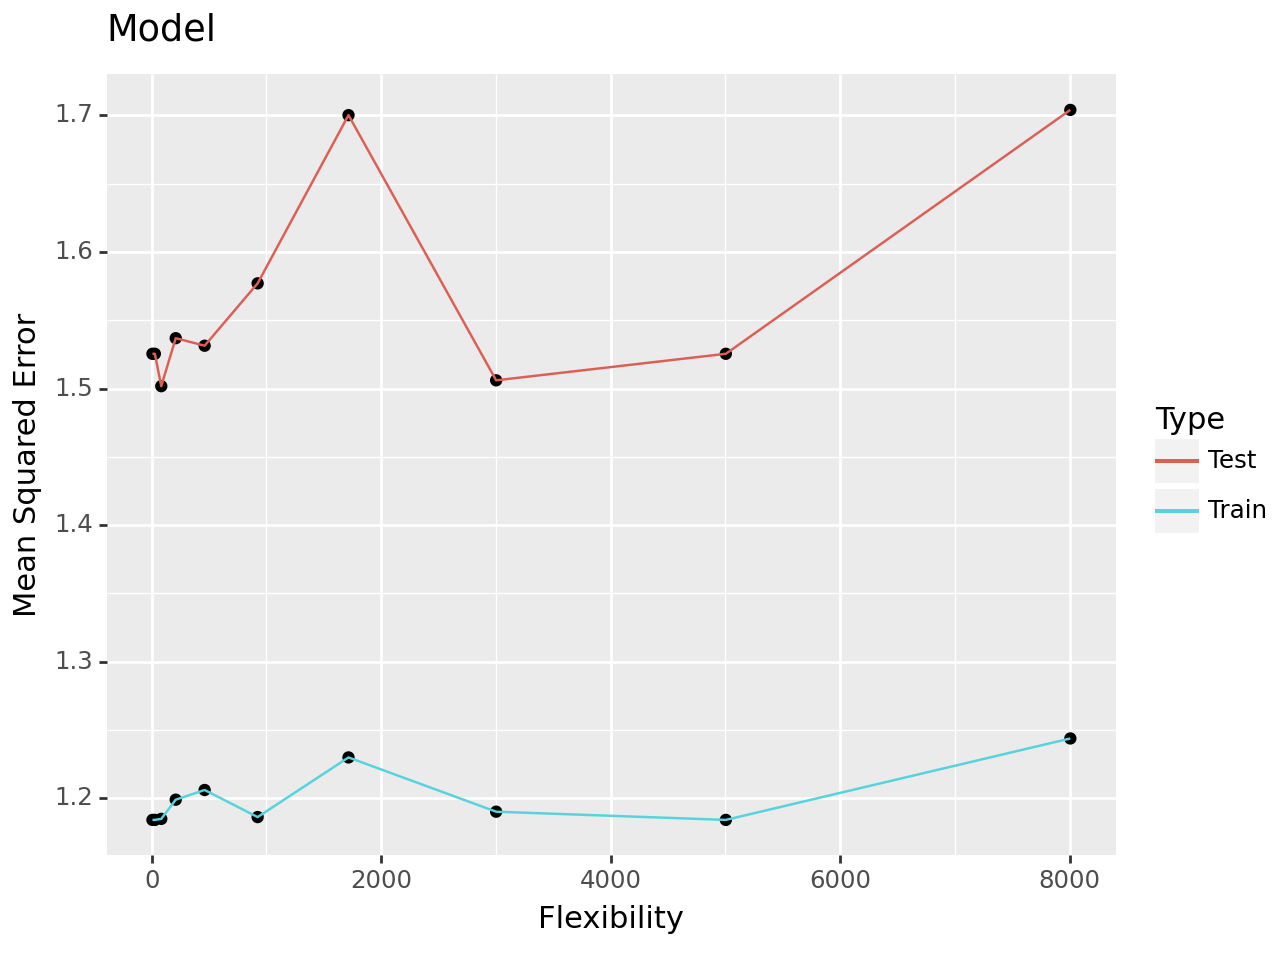

In [135]:
flex_plot(degreelst,model1)

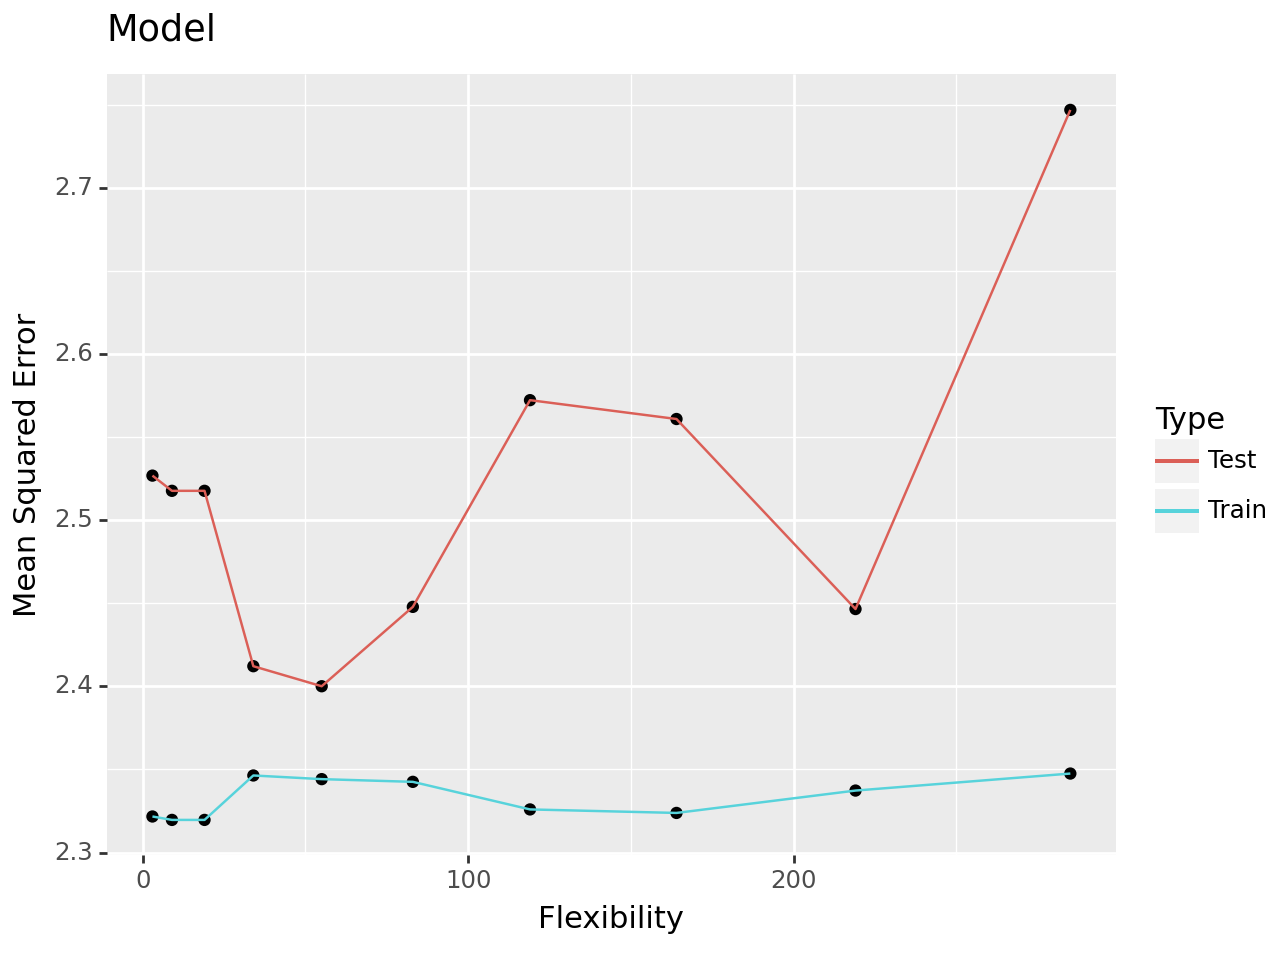

In [136]:
flex_plot(degreelst,model2)

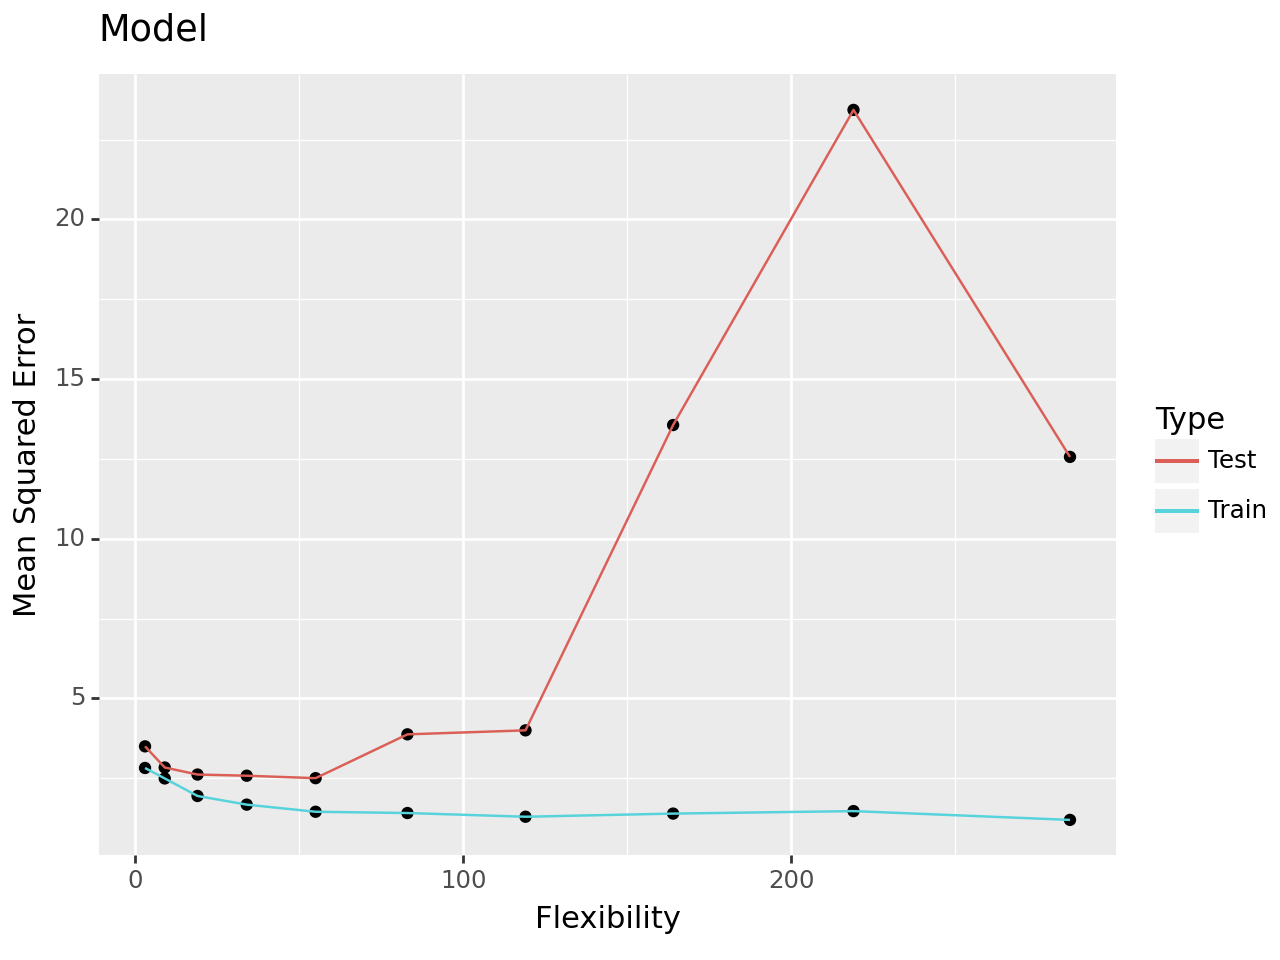

In [137]:
flex_plot(degreelst,model3)

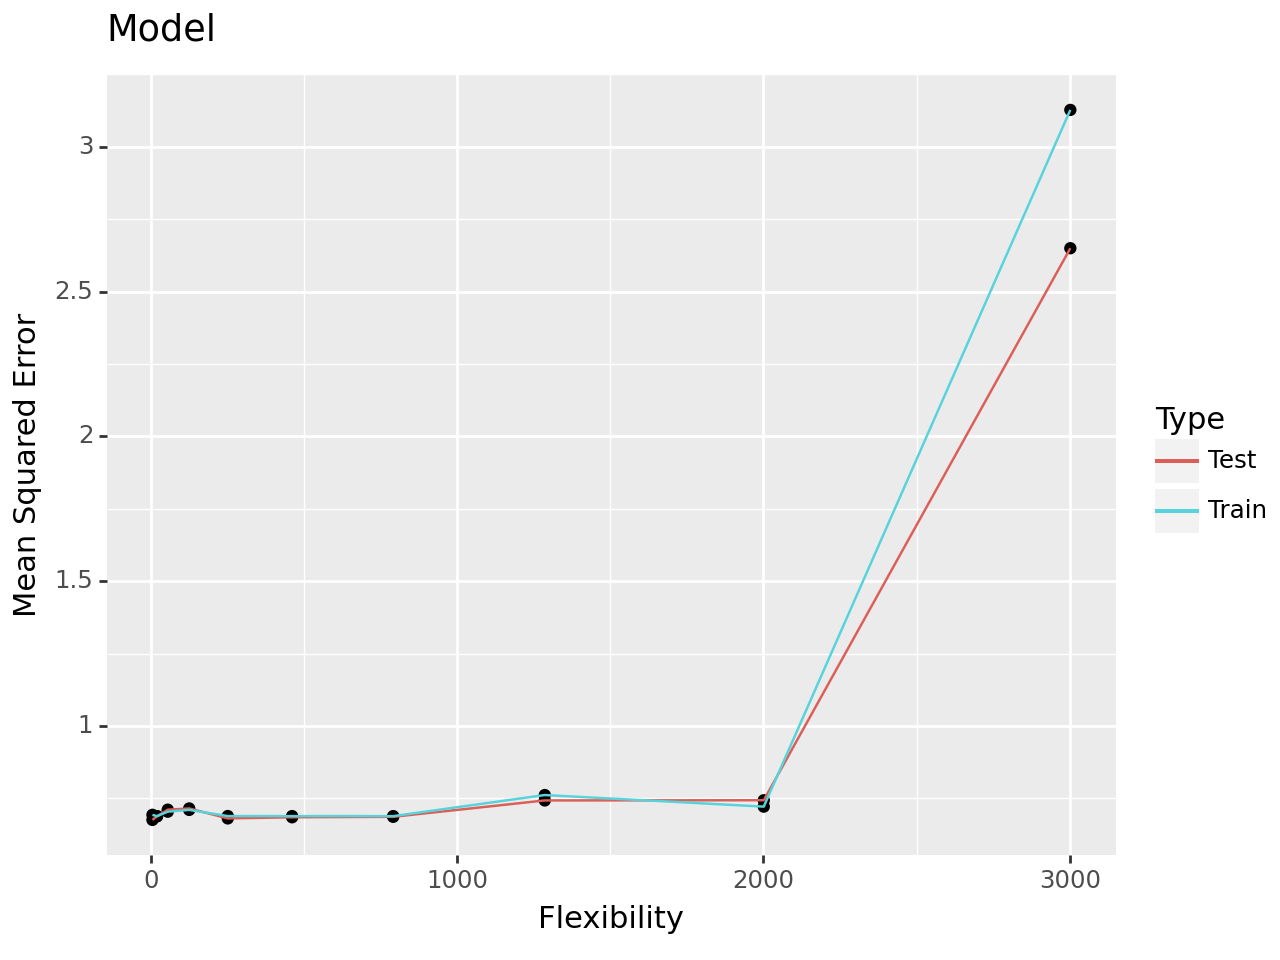

In [138]:
flex_plot(degreelst,model4)

Seems like around the 500-1000 flexibility mark for this split, model1 has the test set begin diverging. For model2 the divergence is also at around the 50 mark. For model3, There is some divergence beginning at about 50, but very steep divergence at about 125. And model4 doesn't actually appear to have the obvious divergence between test and train that we expect.

Model 3 appears to be the worst, highest MSE and divergence. Whereas model 4 appears the best. For the lower and more useful polynomial degrees, the test and train are consistently close and non-diverging as well as having very low overall MSE.

All of the results are specific to the particular way that the data was split under a set randomness seed. If a different seed is chosen, we can get very different results.

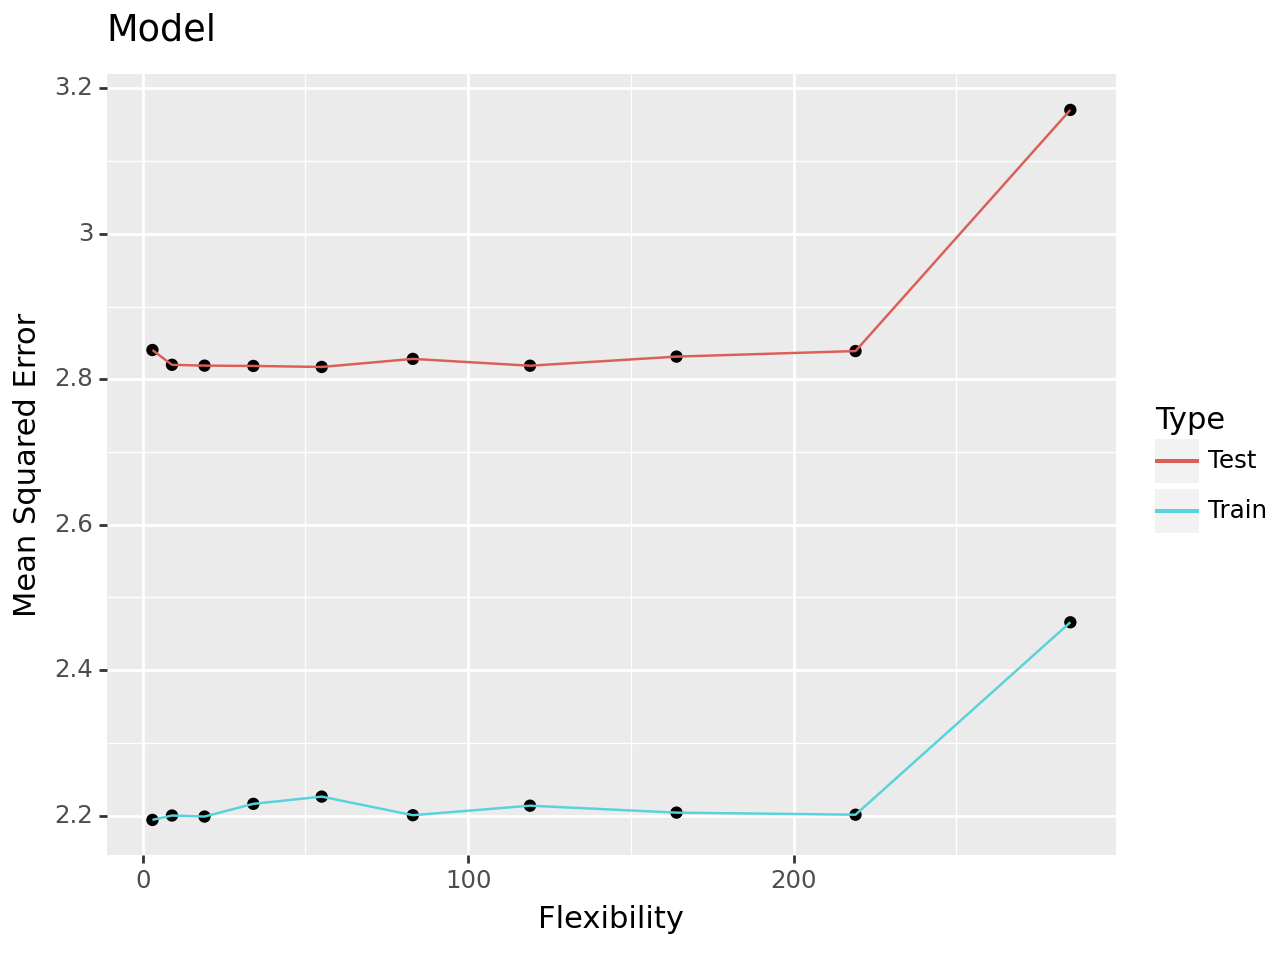

In [147]:
#e.g.
flex_plot(degreelst,model2,3)

Now model 2 appears to be relatively non-diverging too with this split